In [2]:
import os
import json
import fnmatch
import time
import random
from glob import glob
from wordcloud import WordCloud
from collections import Counter
from bids import BIDSLayout
from bids.exceptions import BIDSConflictingValuesError, BIDSValidationError
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Define Some functions

In [3]:
def check_columns_in_events(sub_event_df, data_task_descriptor):
    assert isinstance(sub_event_df, pd.DataFrame), "sub_event_df should be a pandas DataFrame"
    assert isinstance(data_task_descriptor, dict), "data_task_descriptor should be a dictionary"

    results = []

    for events_cols in sub_event_df.columns:
        col_type = "neither"
        exists_in_data = events_cols in data_task_descriptor.keys()
        
        # check if col in task .json in root
        if exists_in_data:
            # is col numeric/int/float or str/object
            if pd.api.types.is_object_dtype(sub_event_df[events_cols]):
                col_type = "object"
                
                # categorical should have levels associated to describe
                if 'Levels' not in data_task_descriptor[events_cols]:
                    levels_check = "Levels key missing in data descriptor"

                    # each levels will have 1=+ values, get unique
                    try:
                        unique_values = sub_event_df[events_cols].unique()
                    except Exception as e:
                        unique_values = []
                        levels_check = f"Could not get unique values from column {events_cols}: {e}"

                    # add to running list
                    for check in unique_values:
                        results.append({
                            'events_column': events_cols,
                            'string_unique': check,
                            'data_type': col_type,
                            'column_in_descriptor': exists_in_data,
                            'string_unique_in_levels': levels_check
                        })
                else:
                    # each levels will have 1=+ values, get unique
                    try:
                        unique_values = sub_event_df[events_cols].unique()
                    except Exception as e:
                        unique_values = []
                        levels_check = f"Could not get unique values from column {events_cols}: {e}"
                    
                    # sometimes categorical variables written as uppercase but levels may be lowercase
                    lower_keys = {k.lower() for k in data_task_descriptor[events_cols]['Levels'].keys()}
                    
                    # is string in columns in levels
                    levels_check = []
                    for string_val in unique_values:
                        if isinstance(string_val, str) and string_val.lower() in lower_keys:
                            levels_check.append(f"{string_val}: Exists in Levels")
                        else:
                            levels_check.append(f"{string_val}: Missing from Levels")
                
                    # add to running list
                    for check in levels_check:
                        results.append({
                            'events_column': events_cols,
                            'string_unique': check.split(':')[0],
                            'data_type': col_type,
                            'column_in_descriptor': exists_in_data,
                            'string_unique_in_levels': check
                        })
                
            elif pd.api.types.is_numeric_dtype(sub_event_df[events_cols]):
                col_type = "numeric"
                
                # same as above, but doing numeric dtype check
                results.append({
                    'events_column': events_cols,
                    'string_unique': None,  # No unique value for numeric columns *confirm if studies uses numeric for categories*
                    'data_type': col_type,
                    'column_in_descriptor': exists_in_data,
                    'string_unique_in_levels': None  # No levels check for numeric
                })
        else:
            # events column not in data descriptor, still add none info
            results.append({
                'events_column': events_cols,
                'string_unique': None,
                'data_type': col_type,
                'column_in_descriptor': exists_in_data,
                'string_unique_in_levels': None
            })

    return pd.DataFrame(results)


def create_file_existence_df(root_dir, files):
    dfs = []
    folder_data = []
    for study_name in opne_folders:
        for file_name in ["participants.json", "participants.tsv", "dataset_description.json"]:
            folder_data.append({
                        'dataset': os.path.basename(study_name),
                        'type': file_name,
                        'exists': file_name in os.listdir(study_name)
                })
            
            df = pd.DataFrame(folder_data)
        dfs.append(df)
    
    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df[~final_df['dataset'].str.contains('outdata', case=False, na=False)]
    return final_df

def participant_col_list(file_list):
    col_list_df = pd.DataFrame(columns=['study_id', 'column_name'])

    for file in file_list:
        study_id = file.split('/')[-2]
        
        try:
            dat = pd.read_csv(file, sep='\t', encoding='utf-8')
        except Exception:
            try:
                dat = pd.read_csv(file, sep='\t', on_bad_lines='warn')
            except Exception:
                dat = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
        
        data_rows = [{'study_id': study_id, 'column_name': col} for col in dat.columns]

        col_list_df = pd.concat([col_list_df, pd.DataFrame(data_rows)], ignore_index=True)
    
    return col_list_df

def participant_col_values(file_list, col_list):
    results_df = pd.DataFrame(columns=['study_id', 'column_name', 'values'])

    # lowercase for case-insensitive matching
    columns_lowcase = [col.lower() for col in col_list]

    for file in file_list:
        study_id = file.split('/')[-2]
        
        try:
            dat = pd.read_csv(file, sep='\t', encoding='utf-8')
        except Exception:
            try:
                dat = pd.read_csv(file, sep='\t', on_bad_lines='warn')
            except Exception:
                dat = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
        
        # column names to lowercase for case-insensitive comparison
        columns_lower = {col.lower(): col for col in dat.columns}
        
        # get matching upper/lower cols
        matching_columns = set(columns_lowcase) & set(columns_lower.keys())
        
        for col_lower in matching_columns:
            actual_col_name = columns_lower[col_lower]
            values = dat[actual_col_name].tolist() 
            
            # add row to df
            data_rows = [{'study_id': study_id, 
                          'column_name': actual_col_name, 
                          'values': value} for value in values]
            
            results_df = pd.concat([results_df, pd.DataFrame(data_rows)], ignore_index=True)
    
    return results_df


In [137]:
def get_descriptor_data(bids_path, task_name):
    descriptor_file = os.path.join(bids_path, f'task-{task_name}_events.json')
    if os.path.exists(descriptor_file):
        with open(descriptor_file, 'r') as file:
            descriptor_data = json.load(file)
            
        return True, descriptor_data 
    else:
        return False, None
    
def exist_datadesc_part_files(bids_path):

    part_json = os.path.exists(f'{bids_path}/participants.json')
    part_tsv = os.path.exists(f'{bids_path}/participants.tsv')
    datadesc_json = os.path.exists(f'{bids_path}/dataset_description.json')

    return datadesc_json, part_json, part_tsv

def exist_bold_nonrest(bids_layout):
    # does BOLD data exist, if not, skip.
    files = bids_layout.get(suffix='bold', extension='.nii.gz')
    if not files: 
        return False, None
    
    # are non-rest tasks present?
    list_tasks = bids_layout.get_tasks()
    if all(task in ['rest', 'resting'] for task in list_tasks):
        return True, False
    
    return True, True
        

def extract_info_from_path(path):
    base_file_noext = os.path.splitext(os.path.basename(path))[0]
    sub_parts = base_file_noext.split('_')
    
    # extract sub-, ses-, task-, and run- info details
    sub_id = next((part.split('-')[1] for part in sub_parts if part.startswith('sub-')), None)
    ses_num = next((part.split('-')[1] for part in sub_parts if part.startswith('ses-')), None)
    task_lab = next((part.split('-')[1] for part in sub_parts if part.startswith('task-')), None)
    run_num = next((part.split('-')[1] for part in sub_parts if part.startswith('run-')), None)
    
    return sub_id, ses_num, task_lab, run_num


def get_events_df(bids_layout, sub, task, sess=None, run=None):
    time.sleep(1)

    kwargs = {'subject': sub, 'task': task, 'suffix': 'events', 'extension': '.tsv', 'return_type': 'filename'}
    if sess is not None:
        kwargs['session'] = sess
    if run is not None:
        kwargs['run'] = run
    
    try:
        result = bids_layout.get(**kwargs)
        
        if not result or len(result) == 0:
            return None
        
        print(f"File retrieved for {kwargs}")
        file_path = result[0]
        return pd.read_csv(file_path, sep='\t')
    
    except Exception as e:
        print(f"Error retrieving or reading file for {kwargs}: {e}")
        return None


def process_events(pd_events, study_id, taskname, subj_id, sess_id, run_id, task_descriptor_info):
    if pd_events is not None:
        try:
            events_vals = check_columns_in_events(sub_event_df=pd_events, data_task_descriptor=task_descriptor_info)
            events_vals['study'] = study_id
            events_vals['subject'] = subj_id
            events_vals['session'] = sess_id
            events_vals['run'] = run_id
            events_vals['task'] = taskname
            return events_vals
        except Exception as e:
            print(f"Error processing events data")
    else:
        print(f"No File Present")

# 1. Availability of three primary files

In [138]:
outdata ='/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro'
opne_folders = glob(f'{outdata}/*')
len(opne_folders)


1109

In [139]:
files_to_check = ["participants.json", "participants.tsv", "dataset_description.json"]

file_existence_df = create_file_existence_df(outdata, files_to_check)

# Save the DataFrame to a CSV file
file_existence_df.to_csv('file_existence_summary.csv', index=False)

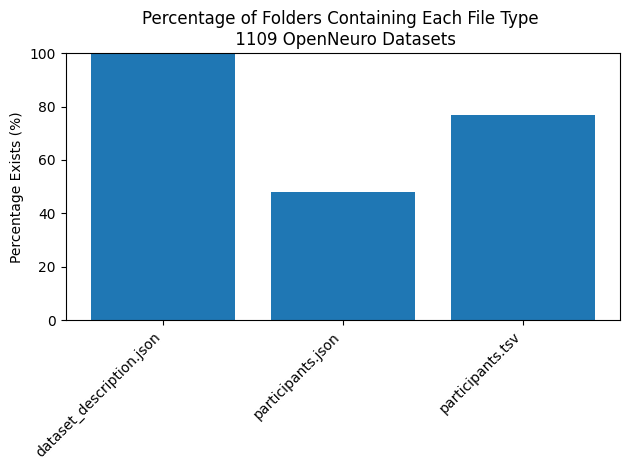

In [140]:
percent_type = file_existence_df.groupby('type')['exists'].mean() * 100
percent_type = percent_type.reset_index()
percent_type.columns = ['type','percent']
plt.bar(percent_type['type'], percent_type['percent'])
plt.xlabel('')
plt.ylabel('Percentage Exists (%)')
plt.title(f'Percentage of Folders Containing Each File Type \n {len(opne_folders)} OpenNeuro Datasets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 2. Column Types and Frequency in Participants.tsv

In [141]:
file_list = glob(f'{outdata}/**/participants.tsv')
len(file_list)

848

In [142]:
columns_df = participant_col_list(file_list)

b'Skipping line 14: expected 16 fields, saw 17\n'
b'Skipping line 14: expected 16 fields, saw 17\n'


### Word cloud of words in columns

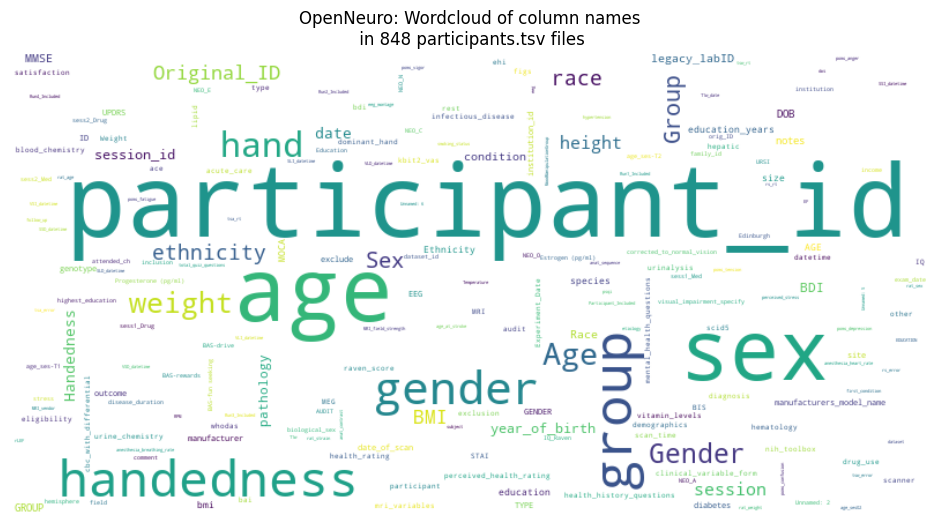

In [143]:
freq_words = Counter(columns_df['column_name'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(freq_words)

# Plot the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'OpenNeuro: Wordcloud of column names \n in {len(file_list)} participants.tsv files ')
plt.show()

### Frequency of words for the top 20 words

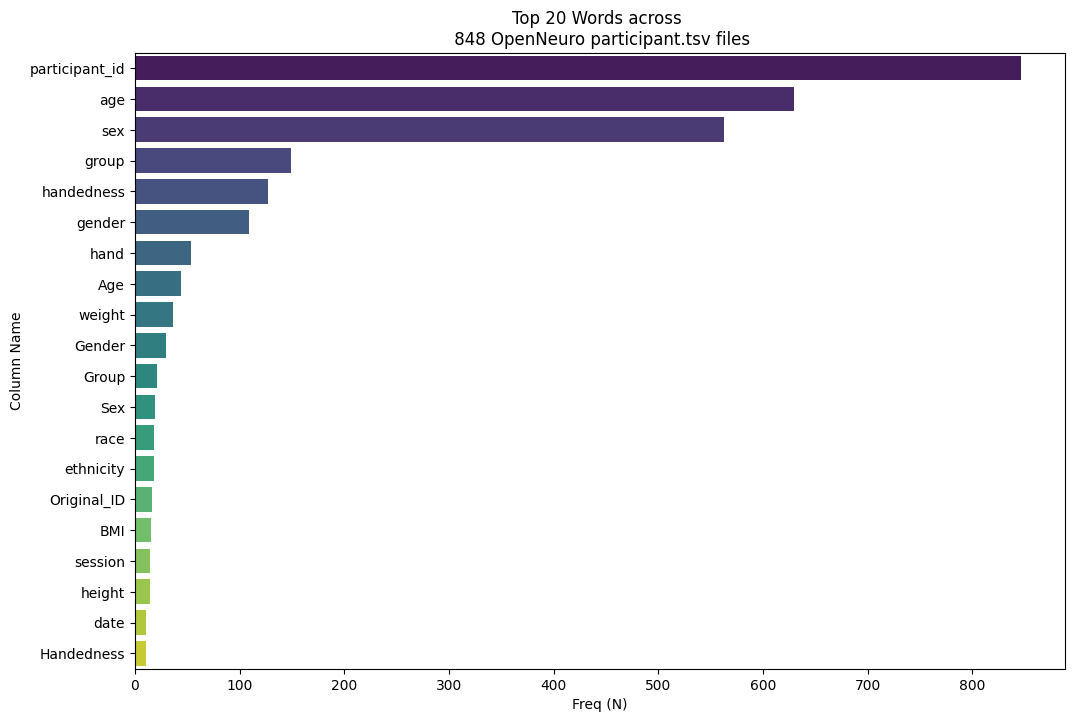

In [144]:
freq_words = Counter(columns_df['column_name'])

# pick top 25
top_25_words = dict(freq_words.most_common(20))
top_words_df = pd.DataFrame(list(top_25_words.items()), columns=['name', 'freq'])


plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Top 20 Words across \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Column Name')
plt.show()

# 3. Types of Values for primary columns

In [145]:
columns_name_eval = ['age','sex','gender','handedness','hand']
columns_values_df = participant_col_values(file_list,columns_name_eval)

b'Skipping line 14: expected 16 fields, saw 17\n'
b'Skipping line 14: expected 16 fields, saw 17\n'


In [146]:
sex_values = columns_values_df[columns_values_df['column_name']=='sex']
gender_values = columns_values_df[columns_values_df['column_name']=='gender']
handedness = columns_values_df[columns_values_df['column_name']=='handedness']

### Frequncy of values for sex/Sex columns

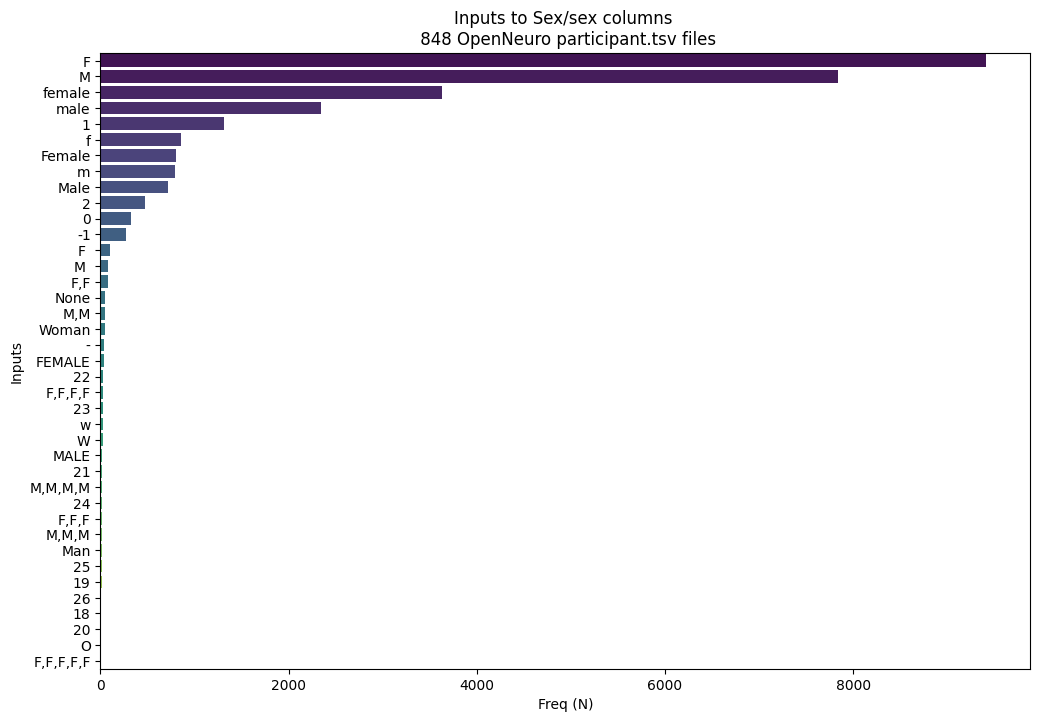

In [147]:
freq_words = Counter(sex_values['values'])

# pick top 40
top_40_words = dict(freq_words.most_common(40))

top_words_df = pd.DataFrame(list(top_40_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to Sex/sex columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Frequncy of values for Gender/gender columns

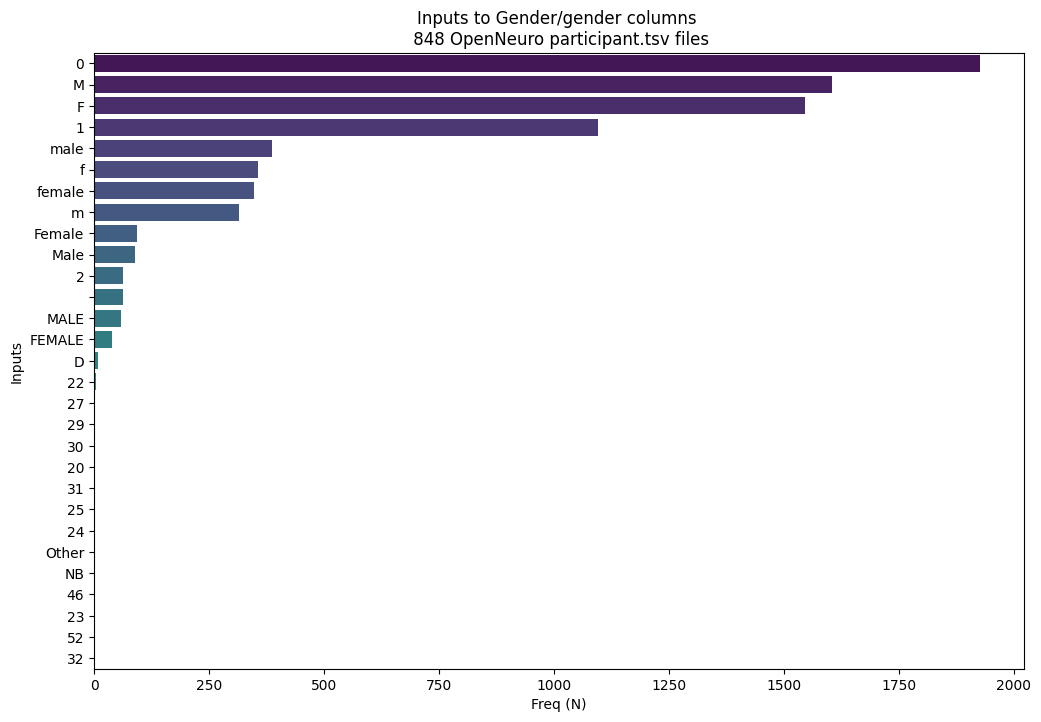

In [148]:
freq_words = Counter(gender_values['values'])

# pick top 30
top_30_words = dict(freq_words.most_common(30))

top_words_df = pd.DataFrame(list(top_30_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to Gender/gender columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Frequncy of values for Handedness/handedness columns

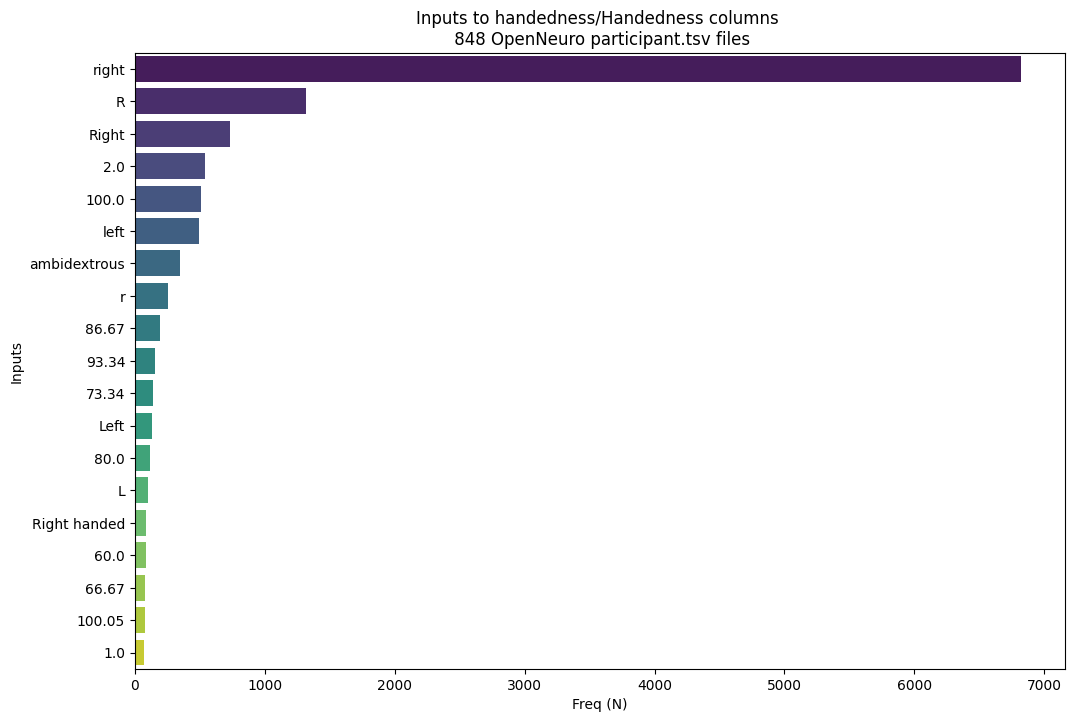

In [149]:
freq_words = Counter(handedness['values'])

top_20_words = dict(freq_words.most_common(20))

top_words_df = pd.DataFrame(list(top_20_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to handedness/Handedness columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Inspecting `int` when Expecting `str`

A number of the string variables, such as sex, gender and handedness, have intergers included. Is this a coding error on my part or a data issue?

In [150]:
gender_values[gender_values['values'].apply(lambda x: isinstance(x, int))].sort_values('values')

,study_id,column_name,values
18740,ds003424,gender,0
56299,ds004186,gender,0
56300,ds004186,gender,0
56301,ds004186,gender,0
56302,ds004186,gender,0
...,...,...,...
58163,ds003357,gender,38
58154,ds003357,gender,46
58176,ds003357,gender,51
58157,ds003357,gender,52


Reviewing the above dataset `ds003357`, as it is [available on OpenNeuro](https://openneuro.org/datasets/ds003357/versions/1.0.0/file-display/participants.tsv) there are column names/labels that are flipped. For example gender <--> age. Which is a think that occurs in some other datasets, too.

In [151]:
pd.read_csv('/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds003357/participants.tsv',
            sep='\t')

,participant_id,group,gender,age
0,sub-01,biofeedback,31,F
1,sub-02,biofeedback,22,F
2,sub-03,biofeedback,25,F
3,sub-04,biofeedback,46,M
4,sub-05,biofeedback,27,F
5,sub-06,biofeedback,23,M
6,sub-07,biofeedback,52,M
7,sub-08,biofeedback,29,M
8,sub-09,biofeedback,27,M
9,sub-10,biofeedback,32,F


## Checking File Contents & Sub/Run/Sess Ns

In [6]:
dir_list = glob('/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/*/')
len(dir_list)

1109

In [22]:
study_info_general = []
combined_dataframes = []
counter = 0

for study_dir in dir_list:
    counter = counter + 1
    print('#',counter, study_dir)

    study_name = os.path.basename(os.path.dirname(study_dir))
    datadesc_exist, partjson_exist, parttsv_exist = exist_datadesc_part_files(os.path.dirname(study_dir))
    try:
        layout_study = BIDSLayout(study_dir)
        study_subs = layout_study.get_subjects()
        study_tasks = layout_study.get_tasks()
        study_runs = layout_study.get_runs()
        study_sess = layout_study.get_sessions()
        bold_exist, nonrest_exist= exist_bold_nonrest(
            bids_layout=layout_study
        )

        study_tasks_nonrest = [task for task in layout_study.get_tasks() if task not in ['rest', 'resting']]


        task_labels_list = []
        descriptor_exists_list = []

        if nonrest_exist:
            for tasklab in study_tasks_nonrest:
                descriptor_exists, descriptor_data = get_descriptor_data(bids_path=study_dir,
                                                                        task_name = tasklab)
                task_labels_list.append(tasklab)
                descriptor_exists_list.append(descriptor_exists)

                if descriptor_exists:
                    for sub in study_subs:
                        sub_events_list = layout_study.get(subject=sub, task=tasklab, suffix= 'events', extension= '.tsv', 
                                                        return_type='filename')
                        for sub_file in sub_events_list:
                            _,ses_num,_,run_num = extract_info_from_path(sub_file[0])
                            sub_events_df = pd.read_csv(sub_file, sep='\t')

                            check_eventstaskdesc_pd = process_events(pd_events=sub_events_df, task_descriptor_info=descriptor_data,
                                                                    study_id=study_name, taskname=tasklab,
                                                                    subj_id=sub, sess_id=ses_num, run_id=run_num)
                            
                            combined_dataframes.append(check_eventstaskdesc_pd)
        

        study_info_general.append({
                            'study_name': study_name,
                            'num_subs': len(study_subs) if study_subs else None,
                            'nuum_sess': len(study_runs) if study_subs else "1",
                            'num_runs': len(study_sess) if study_subs else "1",
                            'bold_exists': bold_exist,
                            'nonrest_exists': nonrest_exist,
                            'num_non-rest_tasks': len(study_tasks_nonrest) if study_tasks_nonrest else None,
                            'task_list': task_labels_list if task_labels_list else None,
                            'task_decsriptor_exist': descriptor_exists_list if descriptor_exists_list else None, 
                            'datadesc_exist': datadesc_exist,
                            'partic_json_exist': partjson_exist,
                            'participant_tsv_exist': parttsv_exist,
                            'error_messages': None,
                        })
    except (OSError, BIDSConflictingValuesError, BIDSValidationError, UnicodeDecodeError) as e:
        print("Error for study:", study_name)
        study_info_general.append({
                            'study_name': study_name,
                            'num_subs': None,
                            'nuum_sess': None,
                            'num_runs': None,
                            'bold_exists': None,
                            'nonrest_exists': None,
                            'num_non-rest_tasks': None,
                            'task_list': None,
                            'task_decsriptor_exist': None, 
                            'datadesc_exist': None,
                            'partic_json_exist': None,
                            'participant_tsv_exist': None,
                            'error_messages': str(e).replace('\t', '').replace(',', '') # to avoid csv/tsv parse issues
                        })


# 1 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds003799/
# 2 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds004910/
# 3 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds002674/
# 4 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds001653/
# 5 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds003104/
# 6 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds001461/
# 7 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds002680/
# 8 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds003752/
# 9 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds004577/
# 10 /Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/data/openneuro/ds001839/
# 11 /Users/demidenm/Desktop/Academia/Stanford/9_

In [23]:
final_combined_df = pd.concat(combined_dataframes, ignore_index=True)
final_study_info = pd.DataFrame(study_info_general)
final_combined_df.to_csv('/Users/demidenm/Downloads/final_study_combined_checks.tsv', sep='\t')
final_study_info.to_csv('/Users/demidenm/Downloads/final_study_details.tsv', sep='\t')

# Plotting some results from combined evevts + study info

In [3]:
final_combined_df = pd.read_csv('/Users/demidenm/Downloads/final_study_combined_checks.tsv', sep='\t', low_memory=False)
final_study_info = pd.read_csv('/Users/demidenm/Downloads/final_study_details.tsv', sep='\t', low_memory=False)

In [4]:
final_study_info.columns

Index(['Unnamed: 0', 'study_name', 'num_subs', 'nuum_sess', 'num_runs',
       'bold_exists', 'nonrest_exists', 'num_non-rest_tasks', 'task_list',
       'task_decsriptor_exist', 'datadesc_exist', 'partic_json_exist',
       'participant_tsv_exist', 'error_messages'],
      dtype='object')

91

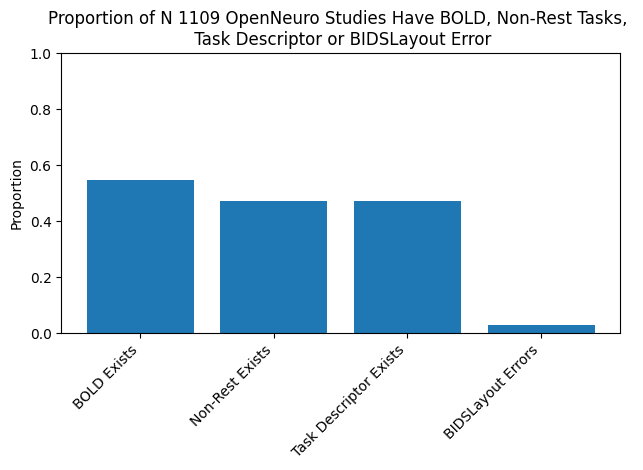

In [9]:
total_n = len(final_study_info)
bids_layouterror = final_study_info['error_messages'].notna().sum() / total_n
bold_proportion = final_study_info['bold_exists'].sum() / total_n
nonrest_proportion = final_study_info['nonrest_exists'].sum() / total_n
task_descr_exist = final_study_info['task_decsriptor_exist'].dropna().apply(lambda x: any(x)).astype(bool).sum() / total_n

plt.bar(['BOLD Exists', 'Non-Rest Exists', 'Task Descriptor Exists', 'BIDSLayout Errors'], 
        [bold_proportion, nonrest_proportion, task_descr_exist, bids_layouterror])
plt.ylabel('Proportion')
plt.title(f'Proportion of N {len(final_study_info)} OpenNeuro Studies Have BOLD, Non-Rest Tasks, \n Task Descriptor or BIDSLayout Error')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



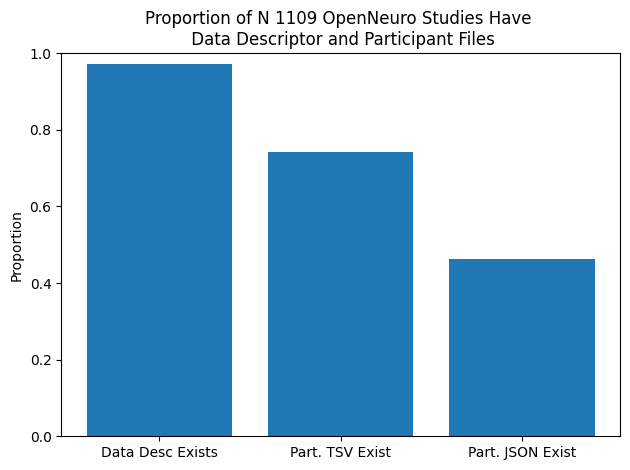

In [183]:
datdesc_proportion = final_study_info['datadesc_exist'].sum() / total_n
partici_json_proportion = final_study_info['partic_json_exist'].sum() / total_n
participant_tsv_proportion = final_study_info['participant_tsv_exist'].sum() / total_n

plt.bar(['Data Desc Exists', 'Part. TSV Exist', 'Part. JSON Exist', ],
        [datdesc_proportion, participant_tsv_proportion, partici_json_proportion])
plt.ylabel('Proportion')
plt.title(f'Proportion of N {len(final_study_info)} OpenNeuro Studies Have \n Data Descriptor and Participant Files')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

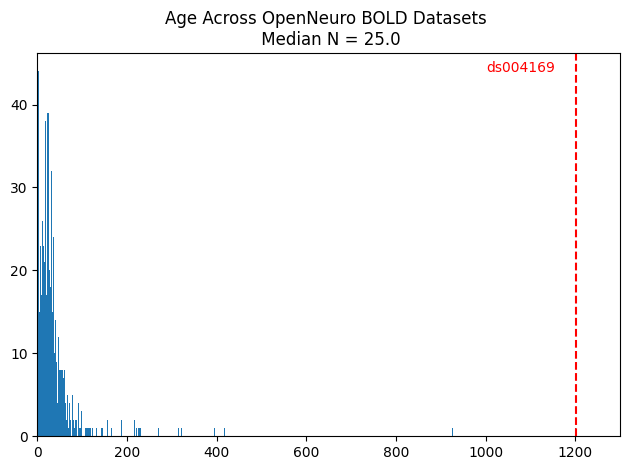

In [157]:
filtered_data = final_study_info[final_study_info['nonrest_exists'] == True]

plt.hist(filtered_data['num_subs'], bins=500)
max_subs = filtered_data['num_subs'].max()
max_label = filtered_data.loc[filtered_data['num_subs'] == max_subs, 'study_name'].values[0]
plt.axvline(max_subs, color='r', linestyle='--')
plt.text(max_subs-200, plt.ylim()[1]*0.95, f'{max_label}', color='r')
plt.xlim(0,1300)
plt.title(f'Age Across OpenNeuro BOLD Datasets \n Median N = {filtered_data["num_subs"].median()}')
plt.tight_layout()
plt.show()

/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_28832/2832325334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['nuum_sess'] = filtered_data['nuum_sess'].fillna(0).astype(int)


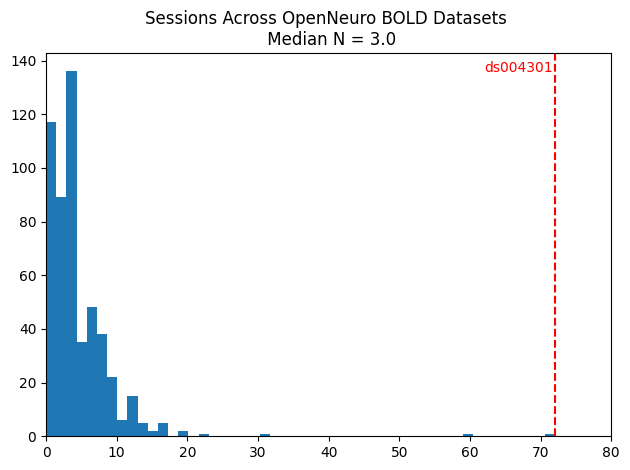

In [159]:
filtered_data['nuum_sess'] = filtered_data['nuum_sess'].fillna(0).astype(int)

plt.hist(filtered_data['nuum_sess'], bins=50)
max_sess = filtered_data['nuum_sess'].max()
max_label = filtered_data.loc[filtered_data['nuum_sess'] == max_sess, 'study_name'].values[0]
plt.xlim(0,80)
plt.axvline(max_sess, color='r', linestyle='--')
plt.text(max_sess-10, plt.ylim()[1]*0.95, f'{max_label}', color='r')

plt.title(f'Sessions Across OpenNeuro BOLD Datasets \n Median N = {filtered_data["nuum_sess"].median()}')
plt.tight_layout()
plt.show()

/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_28832/2609117738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['num_runs'] = filtered_data['num_runs'].fillna(0).astype(int)


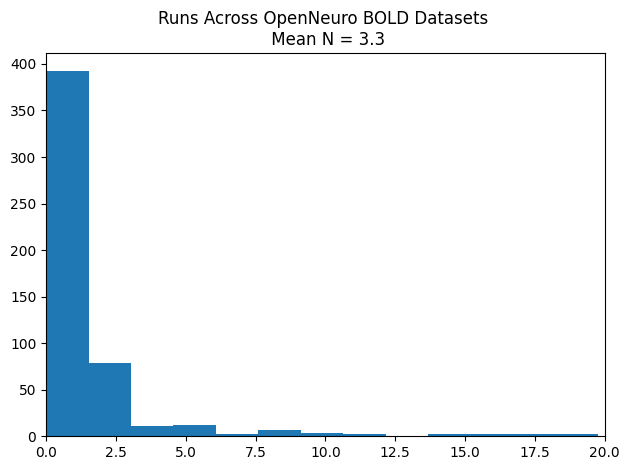

In [160]:
filtered_data['num_runs'] = filtered_data['num_runs'].fillna(0).astype(int)

plt.hist(filtered_data['num_runs'], bins=500)
max_run = filtered_data['num_runs'].max()
max_label = filtered_data.loc[filtered_data['num_runs'] == max_run, 'study_name'].values[0]
plt.xlim(0,20)
plt.title(f'Runs Across OpenNeuro BOLD Datasets \n Mean N = {filtered_data["num_runs"].mean().round(1)}')
plt.tight_layout()
plt.show()

In [5]:
check_levels_miss_str = 'Levels key missing in data descriptor'
string_levels_col = 'string_unique_in_levels'
missing_levels_df = final_combined_df[(final_combined_df['data_type'] == 'object') & (final_combined_df['column_in_descriptor'] == True)]
missing_levels_df = missing_levels_df[
    ~(
        missing_levels_df['events_column'].str.contains('path|file', case=False, na=False) |
        missing_levels_df['string_unique'].str.contains('\.bmp|\.jpg|\.wav', case=False, na=False)
    )
]

missing_levels_df[string_levels_col].apply(lambda x: x == check_levels_miss_str).sum() / len(missing_levels_df)


0.6842181879474871

In [28]:
col_descr_df = final_combined_df[
    ~(
        final_combined_df['events_column'].str.contains('path|file', case=False, na=False) |
        final_combined_df['string_unique'].str.contains('\.bmp|\.jpg|\.wav', case=False, na=False)
    )
]

col_descrfalse_df = final_combined_df[final_combined_df['column_in_descriptor'] == False]
col_descrfalse_df = col_descrfalse_df[
    ~(
        col_descrfalse_df['events_column'].str.contains('path|file', case=False, na=False) |
        col_descrfalse_df['string_unique'].str.contains('\.bmp|\.jpg|\.wav', case=False, na=False)
    )
]

In [12]:
study_ids = missing_levels_df['study'].unique()

prop_misslevels_df = []

for op_study in study_ids:
    study_subs = missing_levels_df[missing_levels_df['study'] == op_study]['subject'].unique()
    rand_sub = random.choice(study_subs)



    sub_vals = missing_levels_df[
        (missing_levels_df['study'] == op_study) &
        (missing_levels_df['subject'] == rand_sub)
    ]
    prop_miss_levels = sub_vals[string_levels_col].apply(lambda x: 
                                                         x == check_levels_miss_str).sum() / len(sub_vals)
    prop_misslevels_df.append(prop_miss_levels)

In [23]:
study_ids = col_descr_df['study'].unique()
prop_missldescr_df = []
for op_study in study_ids:
    study_subs = col_descr_df[col_descr_df['study'] == op_study]['subject'].unique()
    rand_sub = random.choice(study_subs)

    sub_vals = col_descr_df[
        (col_descr_df['study'] == op_study) &
        (col_descr_df['subject'] == rand_sub)
    ]
    prop_miss_decsr = sub_vals['column_in_descriptor'].apply(lambda x: 
                                                         x == False).sum() / len(sub_vals)
    prop_missldescr_df.append(prop_miss_decsr)


/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_51346/3950480675.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=prop_missldescr_df, palette='viridis')


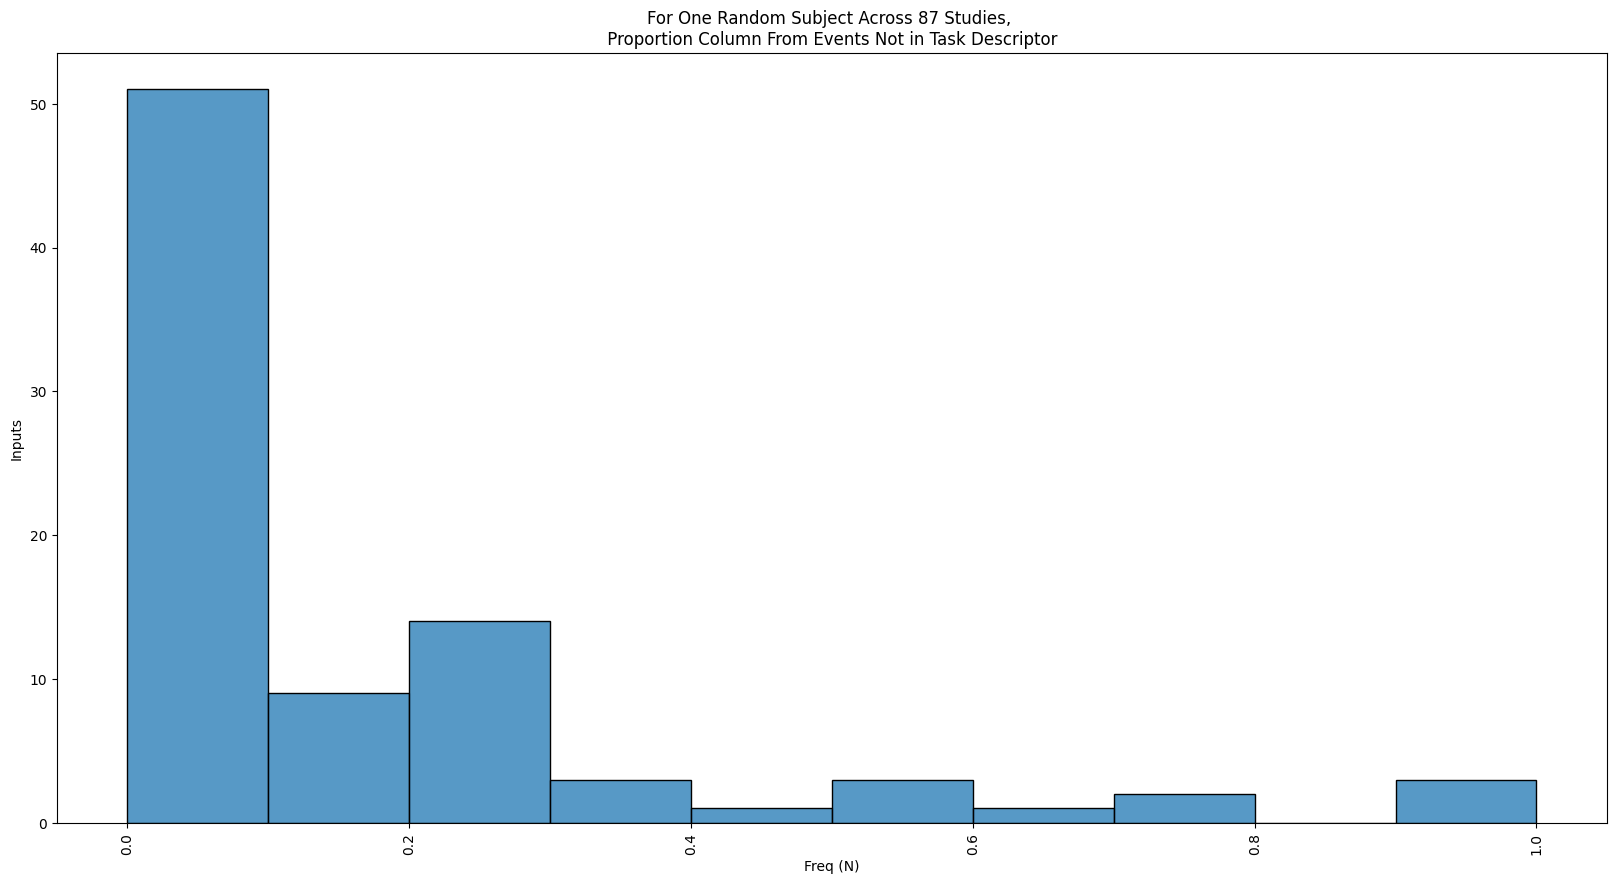

In [69]:

plt.figure(figsize=(20, 10))
sns.histplot(data=prop_missldescr_df, palette='viridis')
plt.title(f'For One Random Subject Across {len(study_ids)} Studies, \n Proportion Column From Events Not in Task Descriptor ')
plt.xticks(rotation=90)
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

/var/folders/nx/gcr6rtnn7l78fw142ttl01d00000gn/T/ipykernel_51346/3062419620.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=prop_misslevels_df, palette='viridis')


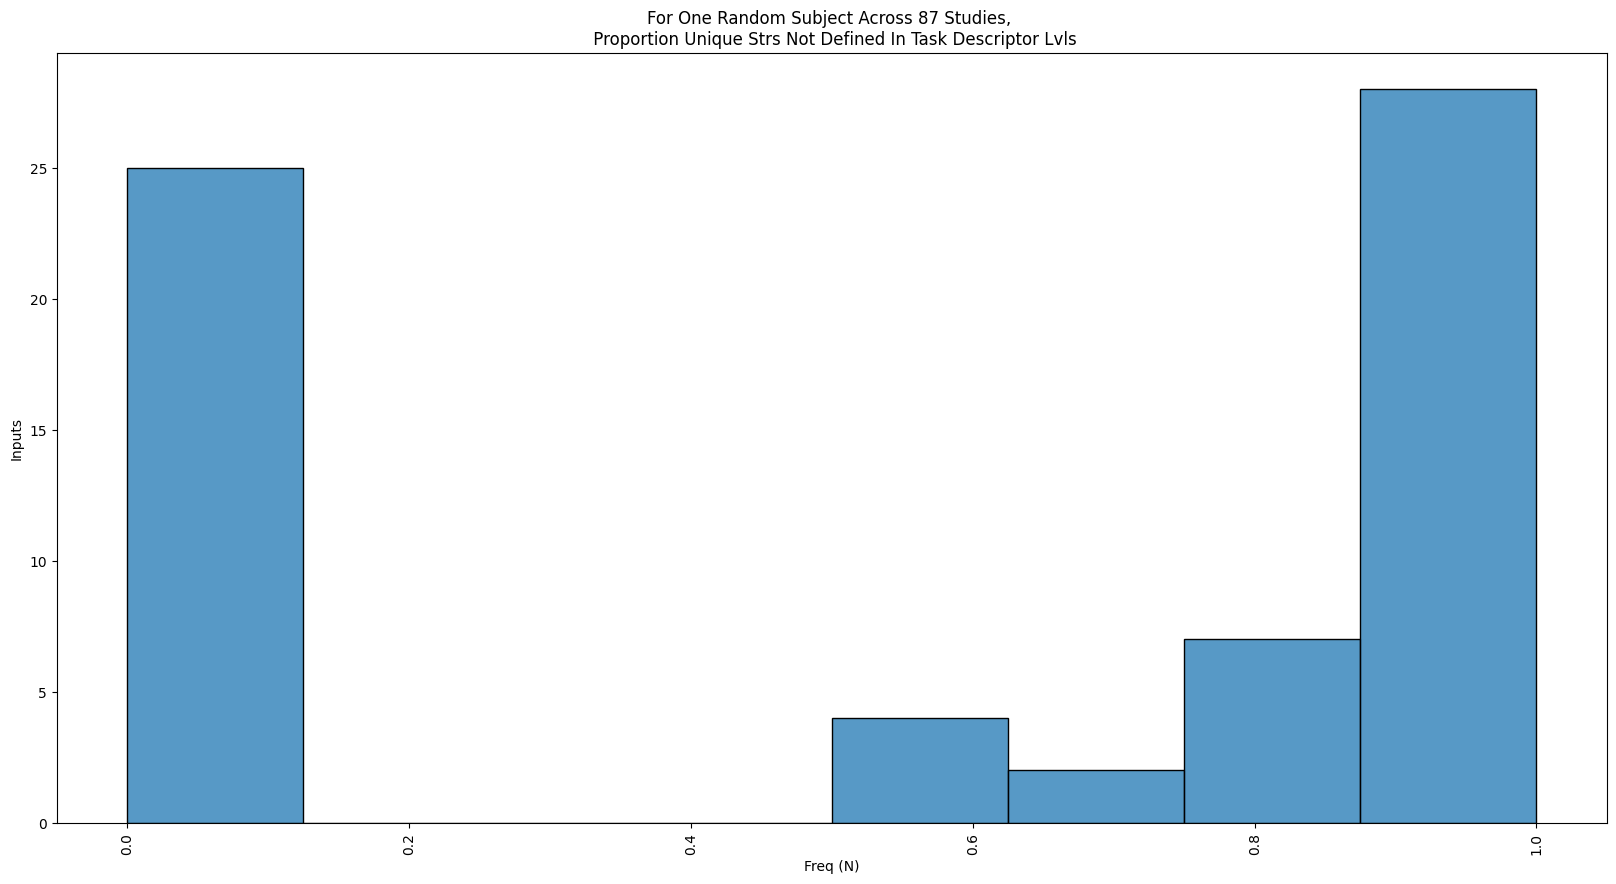

In [70]:
plt.figure(figsize=(20, 10))
sns.histplot(data=prop_misslevels_df, palette='viridis')
plt.title(f'For One Random Subject Across {len(study_ids)} Studies, \n Proportion Unique Strs Not Defined In Task Descriptor Lvls')
plt.xticks(rotation=90)
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

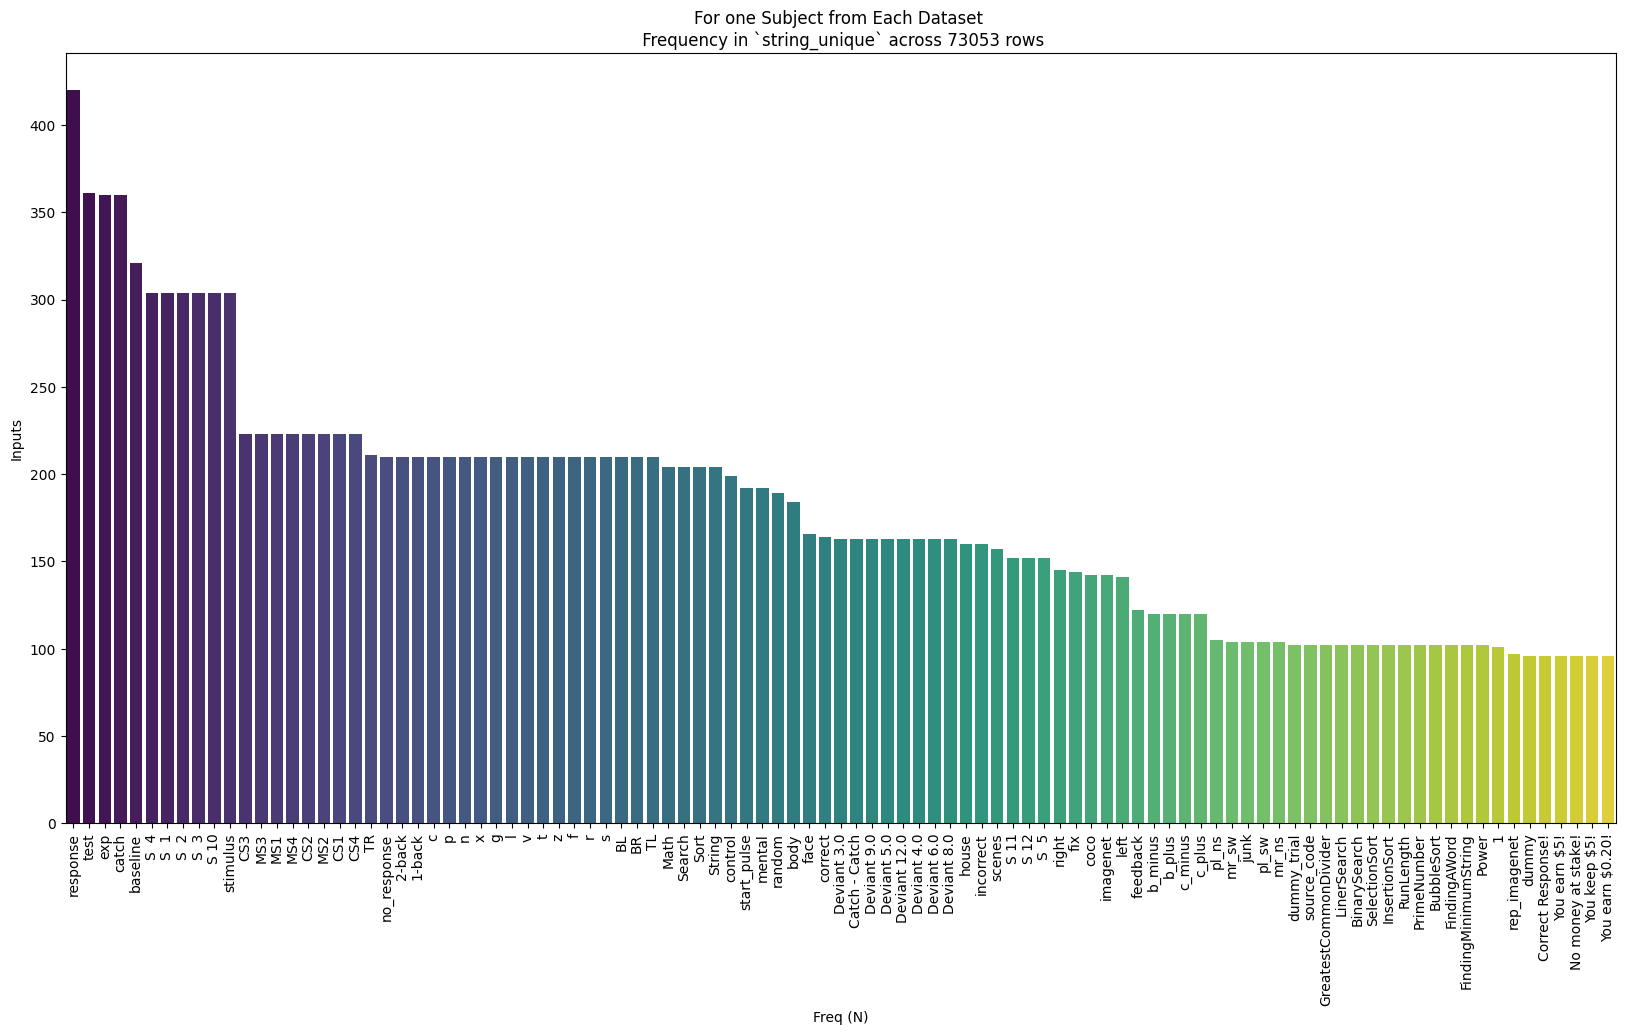

In [49]:
def select_random_subject(df):
    selected_subjects = df.groupby('study')['subject'].apply(lambda x: x.sample(n=1).values[0])
    filtered_df = df[df['subject'].isin(selected_subjects)]
    return filtered_df
col_descr_subsetdf = select_random_subject(col_descr_df)

freq_words = Counter(col_descr_subsetdf['string_unique'])

# pick top 100
top_words = dict(freq_words.most_common(100))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(20, 10))
sns.barplot(data=top_words_df, x='name', y='freq', palette='viridis')
plt.title(f'For one Subject from Each Dataset \n Frequency in `string_unique` across {len(col_descr_subsetdf)} rows')
plt.xticks(rotation=90)
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

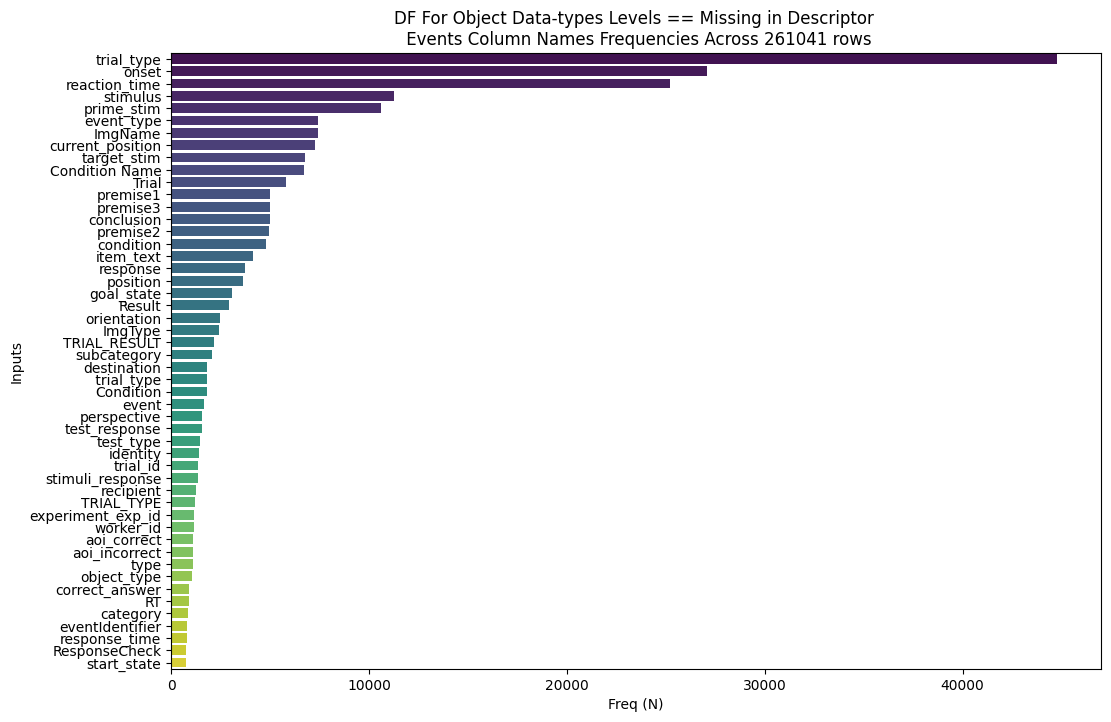

In [32]:
freq_words = Counter(missing_levels_df['events_column'])

# pick top 50
top_words = dict(freq_words.most_common(50))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'DF For Object Data-types Levels == Missing in Descriptor \n Events Column Names Frequencies Across {len(missing_levels_df)} rows')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

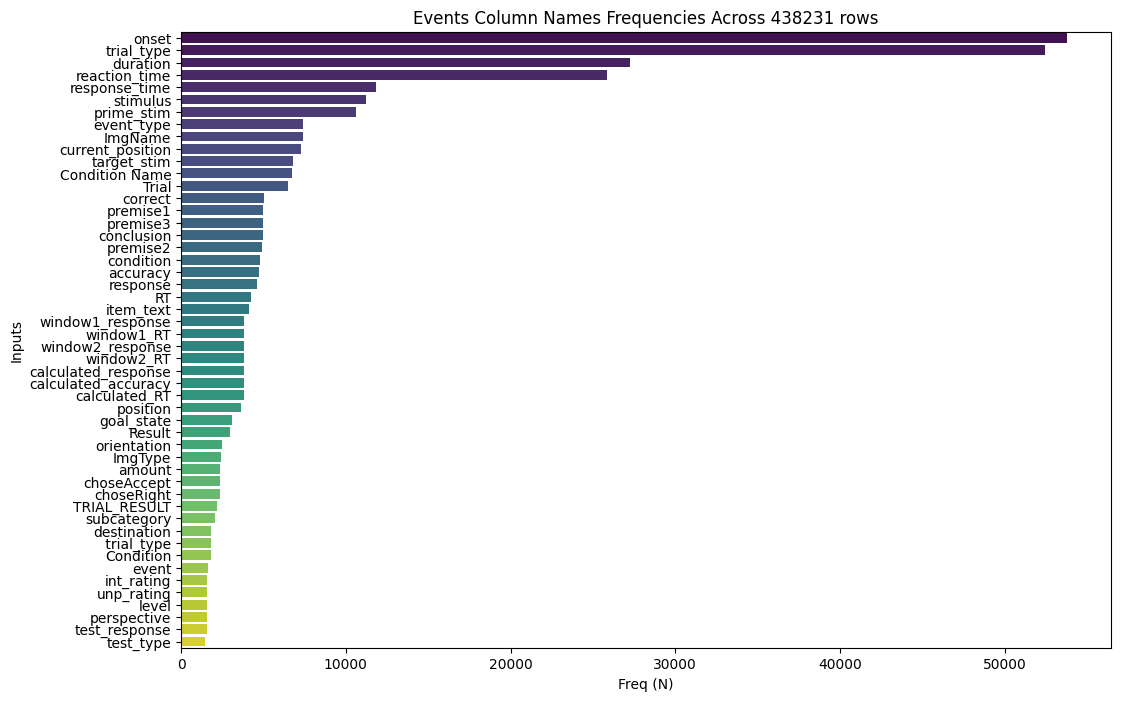

In [27]:
freq_words = Counter(col_descr_df['events_column'])

# pick top 50
top_words = dict(freq_words.most_common(50))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Events Column Names Frequencies Across {len(col_descr_df)} rows')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

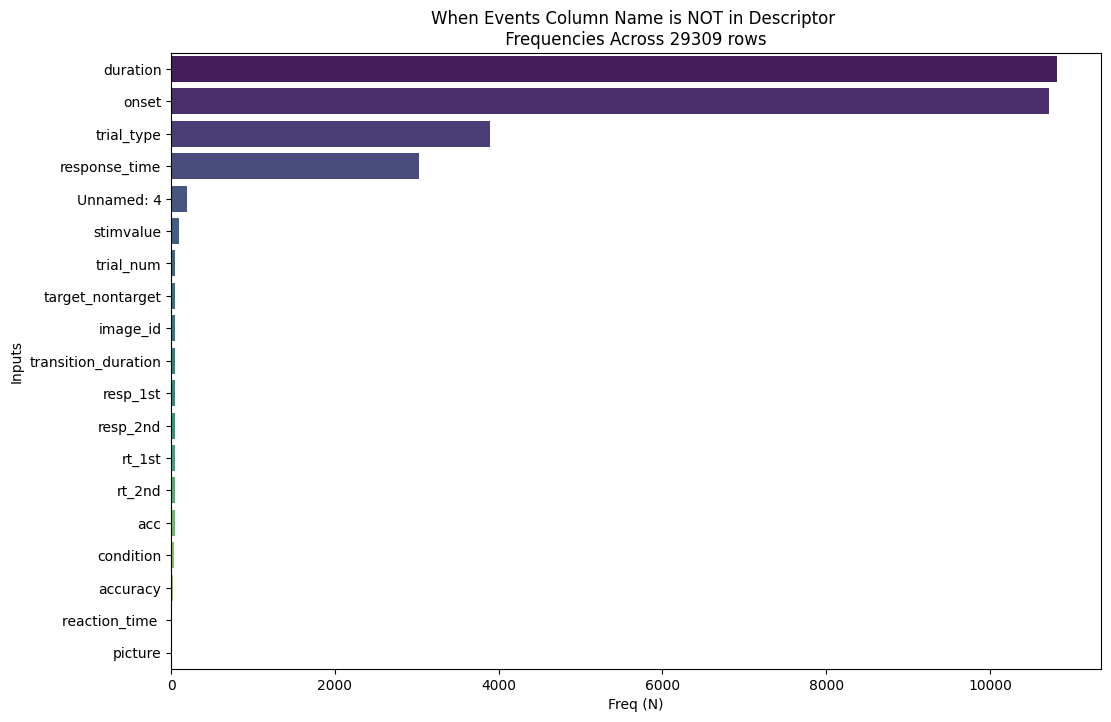

In [30]:
freq_words = Counter(col_descrfalse_df['events_column'])

# pick top 50
top_words = dict(freq_words.most_common(50))

top_words_df = pd.DataFrame(list(top_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'When Events Column Name is NOT in Descriptor \n Frequencies Across {len(col_descrfalse_df)} rows ')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()